<a href="https://colab.research.google.com/github/Reevoc/Tesi/blob/main/Tumori_Benigni_Maligni_25GB_RAM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Network

###Library




In [4]:
import numpy as np 
import os
import keras
import matplotlib.pyplot as plt
import tensorflow as tf

from google.colab.patches import cv2_imshow

from google.colab import drive
from tensorflow.python.client import device_lib
from PIL import Image
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from keras import layers, models, Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.callbacks import ReduceLROnPlateau
from keras import backend
from sklearn.metrics import mean_squared_error, r2_score, classification_report, confusion_matrix

####Usefull installation


In [5]:
!pip install pyyaml h5py

#**Preparazione e download delle immagini**
Le immagini vengono scaricate da google drive, e convertite in array numpy.
Il dataset è composto da 4 cartelle già divise per tumori benigni e maligni per test e train.

Ho utilizzato questa funzione per modificare i nomi delle immagini per permettere l'utilizzio della libreria di keras per la data agumentation


In [6]:
def change_name(cartella, sottocartella):
  x = 0
  for i in os.listdir(f'/content/drive/MyDrive/Dati/{cartella}/{sottocartella}'): 
      if  i.endswith(".jpg"):
        path = os.path.join(f'/content/drive/MyDrive/Dati/{cartella}/{sottocartella}', i)
        path_destination = os.path.join(f'/content/drive/MyDrive/Dati/{cartella}/{sottocartella}', "photo" + str(x) + ".jpg")
        os.rename(path, path_destination)
      x+=1

Le immagini vengono scaricate da google drive, e convertite in array numpy.
Il dataset è composto da 4 cartelle già divise per tumori benigni e maligni per test e train.

In [7]:
drive.mount('/content/drive', force_remount = True)

folder_benign_train = '/content/drive/MyDrive/Dati/train/benign'
folder_malignant_train = '/content/drive/MyDrive/Dati/train/malignant'

folder_benign_test = '/content/drive/MyDrive/Dati/test/benign'
folder_malignant_test = '/content/drive/MyDrive/Dati/test/malignant'

read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))

# Carico le immagini di train
ims_benign = [read(os.path.join(folder_benign_train, filename)) for filename in os.listdir(folder_benign_train)]
X_benign = np.array(ims_benign, dtype='uint8')
print("train beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_train, filename)) for filename in os.listdir(folder_malignant_train)]
X_malignant = np.array(ims_malignant, dtype='uint8')
print("train maligni caricati")

# Carico le immagini di test
ims_benign = [read(os.path.join(folder_benign_test, filename)) for filename in os.listdir(folder_benign_test)]
X_benign_test = np.array(ims_benign, dtype='uint8')
print("test beningi caricati")
ims_malignant = [read(os.path.join(folder_malignant_test, filename)) for filename in os.listdir(folder_malignant_test)]
X_malignant_test = np.array(ims_malignant, dtype='uint8')
print("test maligni caricati")

Mounted at /content/drive
train beningi caricati
train maligni caricati
test beningi caricati
test maligni caricati


###Lables 
Aggiungo la lables a tutte le immagini 0 per un benigno e 1 per un maligno.

In [8]:
y_benign = np.zeros(X_benign.shape[0])
y_malignant = np.ones(X_malignant.shape[0])

y_benign_test = np.zeros(X_benign_test.shape[0])
y_malignant_test = np.ones(X_malignant_test.shape[0])

Concateno i set di train e di test e faccio uno shuffle delle dei tensori

In [9]:
X_train = np.concatenate((X_benign, X_malignant), axis = 0)
y_train = np.concatenate((y_benign, y_malignant), axis = 0)

X_test = np.concatenate((X_benign_test, X_malignant_test), axis = 0)
y_test = np.concatenate((y_benign_test, y_malignant_test), axis = 0)


"""
s = np.arange(X_train.shape[0])
np.random.shuffle(s)
X_train = X_train[s]
y_train = y_train[s]

s = np.arange(X_test.shape[0])
np.random.shuffle(s)
X_test = X_test[s]
y_test = y_test[s]"""

'\ns = np.arange(X_train.shape[0])\nnp.random.shuffle(s)\nX_train = X_train[s]\ny_train = y_train[s]\n\ns = np.arange(X_test.shape[0])\nnp.random.shuffle(s)\nX_test = X_test[s]\ny_test = y_test[s]'

Una visualizzazione rapita compresa di lables delle immagni in una griglia 



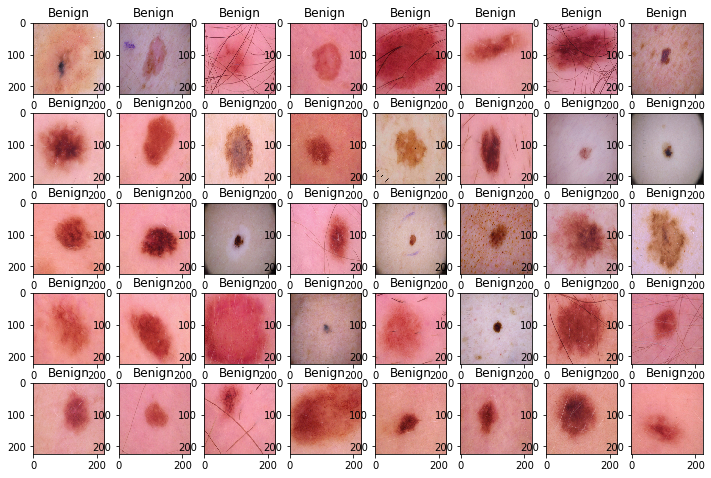

In [10]:
columns = 8
rows = 5
fig=plt.figure(figsize=(12, 8))

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if y_train[i] == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Malignant')
    plt.imshow(X_train[i], interpolation= 'nearest')
plt.show()

###Categorical Lables

In [11]:
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test =tf.keras.utils.to_categorical(y_test, num_classes=2)

###Normalizzo 
eseguo una normalizzazione delle immagini

In [12]:
X_train = X_train/255.0
X_test = X_test/255.0
X_train.shape

(2637, 224, 224, 3)

#Build CNN model 
Il modello è basato su dei layer di Conv2D, e MaxPool2D.
Viene aggiunto anche un layer di dropout per evitare un overfitting della rete.
dopo varie prove ho optato per un'attivazione sigmoid e ottimizzatore rsmprop o softmax attivatore e adam ottimizzatore. Questi sembrano dare i risultati migliori.


In [13]:
#in optin da provare con rmsprop , adam e in activation_Dense con sigmoid , softmax
def CNN_model(input_shape, lr, numclassi, optim, activ, init): 
    
    model = Sequential()

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same',input_shape=input_shape,
                     activation= activ, kernel_initializer='glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3),padding = 'Same', 
                     activation =activ, kernel_initializer = 'glorot_uniform'))
    model.add(MaxPool2D(pool_size = (2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer=init))
    model.add(Dense(numclassi, activation='softmax'))
    model.summary()

    if optim == 'rmsprop':
        optimizer = RMSprop(lr=lr)

    else:
        optimizer = Adam(lr=lr)

    model.compile(optimizer = optimizer ,loss = "binary_crossentropy", metrics=["accuracy"])
    return model

###Learning rate reduction


In [14]:
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_accuracy', patience=5,  verbose=0, factor=0.5,  min_lr=1e-7)

###Plot
plot il modello in base ai valori di loss e accuracy ottenuti dal test train in fase di CNN_model

In [15]:
def plot(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']  
  val_loss = history.history['val_loss']
  epoches = range (1, len(acc)+1)

  plt.plot(epoches, acc, 'bo', label ='Traning accuracy')
  plt.plot(epoches, val_acc, 'b', label ='Validation accuracy')
  plt.title('Traning and Validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epoches, loss, 'bo', label = 'Traning loss')
  plt.plot(epoches, val_loss, 'b', label ='Validation loss')
  plt.title('Traning and Validation loss')
  plt.legend()

  plt.show()
  
def plot_1(history):
  acc = history.history['accuracy']
  loss = history.history['loss']  
  epoches = range (1, len(acc)+1)

  plt.plot(epoches, acc, 'bo', label ='Traning accuracy')
  plt.title('Traning and Validation accuracy')
  plt.legend()
  plt.figure()

  plt.plot(epoches, loss, 'bo', label = 'Traning loss')
  plt.title('Traning and Validation loss')
  plt.legend()

  plt.show()

#Visualizzazione dei filtri


(1, 224, 224, 3)


<function matplotlib.pyplot.show>

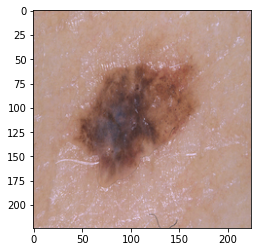

In [16]:
img_path = '/content/drive/MyDrive/Dati/train/benign/photo10.jpg'
img = image.load_img(img_path, target_size = (224, 224))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis = 0)
img_tensor /= 255.
print(img_tensor.shape)
plt.imshow(img_tensor[0])
plt.show

In [17]:
model = CNN_model(lr=1e-5,
                  numclassi = 2,
                  activ= 'relu',
                  optim='adam',
                  input_shape= (224,224,3),
                  init = 'normal')

layers_outputs = [layer.output 
                 for layer in model.layers[:8]]
activation_model = models.Model(inputs = model.input, outputs = layers_outputs)
activation = activation_model.predict(img_tensor)
first_layer_activation = activation[0]
print(first_layer_activation.shape)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

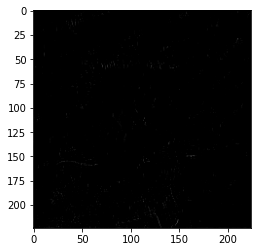

In [18]:
plt.imshow(first_layer_activation[0,:,:,3], cmap = 'gray')

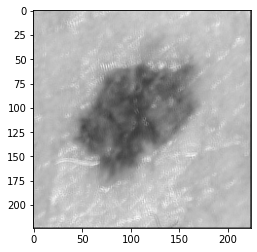

In [19]:
plt.imshow(first_layer_activation[0,:,:,7], cmap = 'gray')

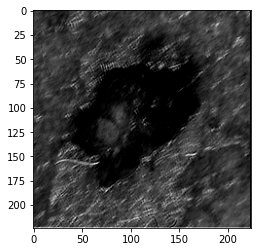

In [20]:
plt.imshow(first_layer_activation[0,:,:,10], cmap = 'gray')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


MemoryError: ignored

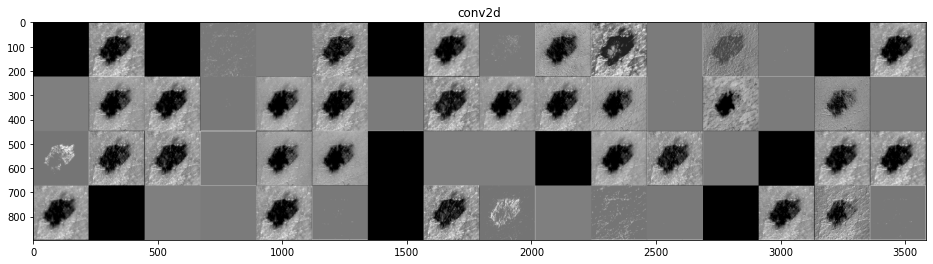

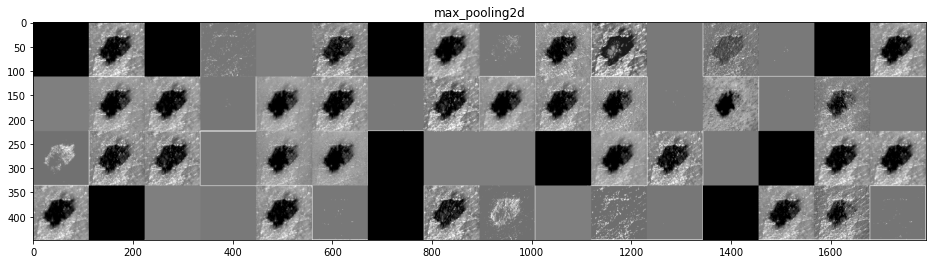

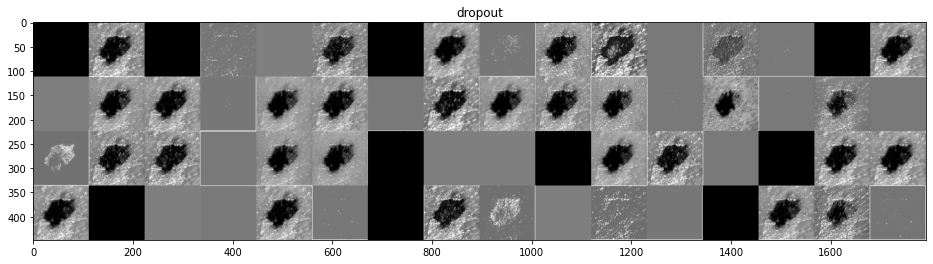

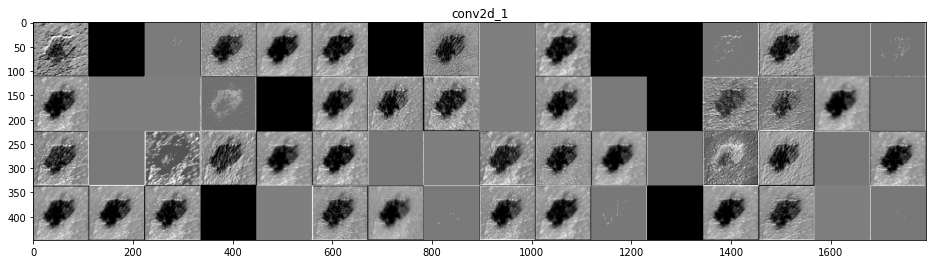

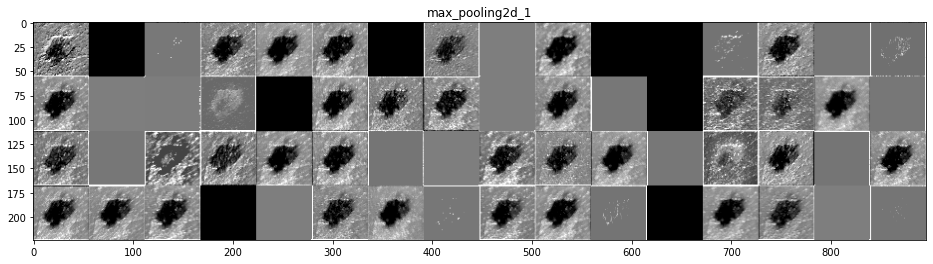

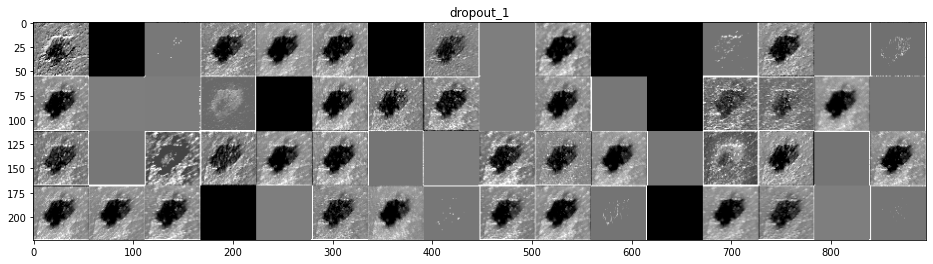

In [21]:
layers_names = []

for layer in model.layers[:8]: #quanti layer ho ??
  layers_names.append(layer.name)

images_per_row = 16
for layer_name, layer_activation in zip(layers_names, activation):
  n_features = layer_activation.shape[-1]
  size = layer_activation.shape[1]
  n_cols = n_features // images_per_row
  display_grid = np.zeros((size * n_cols, images_per_row * size))
  for col in range(n_cols):
    for row in range(images_per_row):
      channel_image = layer_activation[0,:,:,col *images_per_row + row]
      channel_image -= channel_image.mean()
      channel_image /= channel_image.std()
      channel_image *= 64
      channel_image +=128
      channel_image = np.clip(channel_image, 0 , 255).astype('uint8')
      display_grid[col * size : (col +1) * size, row * size : (row +1)* size ] = channel_image
  scale = 1./ size
  plt.figure(figsize = (scale * display_grid.shape[1], scale * display_grid.shape[0]))
  plt.title(layer_name)
  plt.grid(False)
  plt.imshow(display_grid, aspect = 'auto', cmap = 'gray')

#Train the Model


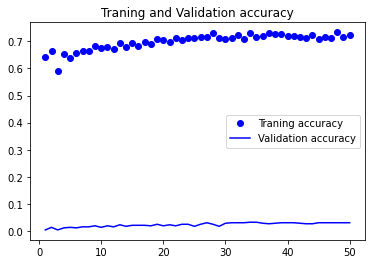

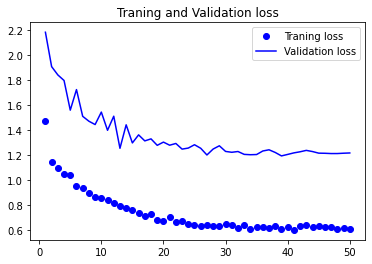

In [22]:
history = model.fit(X_train,
                    y_train,
                    validation_split=0.2,
                    epochs= 50,
                    batch_size= 256,
                    verbose=0, 
                    callbacks=[learning_rate_reduction])
plot(history)
del history

##Cross Validation

In [23]:
def cross_validation(model, input_shape, lr, activ, optim, epochs):
  inputs = X_train
  targets = y_train

  print(f'shape degli input = {inputs.shape}')
  print(f'shape dei target = {targets.shape}')

  #3 k fold
  kfold = KFold(n_splits=3, shuffle=True)
  print(f'values kfold = {kfold}')

  #dove metto gli score
  acc_per_fold = []
  loss_per_fold = []
  fold_no = 1

  for train, test in kfold.split(inputs, targets):
    
    
      #Addestro il modello su una parte dei dati di train
      model.fit(inputs[train], targets[train], epochs=epochs, batch_size= 256, verbose=0)
    
      #score del modello in percentuale
      scores = model.evaluate(inputs[test], targets[test], verbose=0)
      acc_per_fold.append(scores[1] * 100)
      loss_per_fold.append(scores[0])

      # Increase fold number
      fold_no = fold_no + 1

  for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
  print('------------------------------------------------------------------------')
  print('Media degli scores per tutte le folds:')
  print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
  print(f'> Loss: {np.mean(loss_per_fold)}')
  print('------------------------------------------------------------------------')

In [24]:
cross_validation(model = model,
                 input_shape= (224,224,3),
                 lr=1e-5,
                 activ= 'relu',
                 optim='adam',
                 epochs = 50)

shape degli input = (2637, 224, 224, 3)
shape dei target = (2637, 2)
values kfold = KFold(n_splits=3, random_state=None, shuffle=True)
------------------------------------------------------------------------
> Fold 1 - Loss: 0.6147302389144897 - Accuracy: 60.86462140083313%
------------------------------------------------------------------------
> Fold 2 - Loss: 0.61653733253479 - Accuracy: 63.02616596221924%
------------------------------------------------------------------------
> Fold 3 - Loss: 0.5865809321403503 - Accuracy: 67.34926104545593%
------------------------------------------------------------------------
Media degli scores per tutte le folds:
> Accuracy: 63.7466828028361 (+- 2.695922379985845)
> Loss: 0.6059495011965433
------------------------------------------------------------------------


In [25]:
prediction(Model = model, X_test= X_test, y_test=y_test)
backend.clear_session()
del model

accuracy score: 0.65
####################################################################################################
Mean squared error: 0.21
####################################################################################################
Variance score: 0.16
####################################################################################################


##Data Agumentation

In [26]:
def manually_data_agumetation(batches):
  datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
  model = CNN_model(lr=1e-5,
                  numclassi = 2,
                  activ= 'relu',
                  optim='adam',
                  input_shape= (224,224,3),
                  init = 'normal')
  datagen.fit(X_train)
  model.fit(datagen.flow(X_train, y_train, batch_size= batches),
          steps_per_epoch=len(X_train) / batches, epochs=1, batch_size = batches,
           validation_steps = 0.2)
  
  epochs = 20
  for e in range(epochs):
      print('Epoch', e)
      for x_batch, y_batch in datagen.flow(X_train, y_train, batch_size= batches):
          model.fit(x_batch, y_batch, verbose = 0)
          batches += 1
          if batches >= len(X_train) / batches:
            break
  

!significativa differenza con la grandezza dei batch.
il ciclo for con batch + piccola aumenta le immagini aumentate + grande aumenta meno immagini

In [27]:
manually_data_agumetation(256)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
dropout (Dropout)            (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 56, 56, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 200704)            0

In [29]:
  prediction(Model = model, X_test= X_test, y_test = y_test)

NameError: ignored

#Prediction 

In [28]:
def prediction(Model, X_test, y_test):
  y_pred = model.predict(X_test)
  print("accuracy score: %.2f" % accuracy_score(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1)))
  print('####################################################################################################')
  #mean squared error more low is better
  print("Mean squared error: %.2f"
      % mean_squared_error(y_test, y_pred))
  print('####################################################################################################')
  #variance score: 1 is perfect prediction
  print('Variance score: %.2f' % r2_score(y_test, y_pred))
  print('####################################################################################################')



In [ ]:
os.mkdir('/content/drive/My Drive/CNNNh5/CNNmodel_1%01d.h5')
def save_model(epoch, generator):
  filename = '/content/drive/My Drive/CNNNh5/CNNmodel_1%01d.h5' %(epoch)
  generator.save(filename)

In [ ]:
del model 
del history